Загрузите датасет digits с помощью функции load_digits из sklearn.datasets и подготовьте матрицу признаков X и ответы на обучающей выборке y (вам потребуются поля data и target в объекте, который возвращает load_digits).

Для оценки качества далее нужно будет использовать cross_val_score из sklearn.cross_validation с параметром cv=10. Эта функция реализует k-fold cross validation c k равным значению параметра cv. Мы предлагаем использовать k=10, чтобы полученные оценки качества имели небольшой разброс, и было проще проверить полученные ответы. На практике же часто хватает и k=5. Функция cross_val_score будет возвращать numpy.ndarray, в котором будет k чисел - качество в каждом из k экспериментов k-fold cross validation. Для получения среднего значения (которое и будет оценкой качества работы) вызовите метод .mean() у массива, который возвращает cross_val_score.

С небольшой вероятностью вы можете натолкнуться на случай, когда полученное вами качество в каком-то из пунктов не попадет в диапазон, заданный для правильных ответов - в этом случае попробуйте перезапустить ячейку с cross_val_score несколько раз и выбрать наиболее «типичное» значение. Если это не помогает, то где-то была допущена ошибка.

Если вам захочется ускорить вычисление cross_val_score - можете попробовать использовать параметр n_jobs, но будьте осторожны: в одной из старых версий sklearn была ошибка, которая приводила к неверному результату работы cross_val_score при задании n_jobs отличным от 1. Сейчас такой проблемы возникнуть не должно, но проверить, что все в порядке, не будет лишним.



In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets, model_selection, metrics

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
digits = datasets.load_digits()

data = digits.data
target = digits.target

In [3]:
train_data, train_labels, test_data, test_labels = model_selection.train_test_split(data, target, test_size=0.3)

1.

Создайте DecisionTreeClassifier с настройками по умолчанию и измерьте качество его работы с помощью cross_val_score. Эта величина и будет ответом в пункте 1.

In [4]:
from sklearn import tree

In [5]:
tree_classifier = tree.DecisionTreeClassifier()
model_selection.cross_val_score(tree_classifier, data, target, cv=10).mean()

0.8280260707635009

2.Воспользуйтесь BaggingClassifier из sklearn.ensemble, чтобы обучить бэггинг над DecisionTreeClassifier. Используйте в BaggingClassifier параметры по умолчанию, задав только количество деревьев равным 100.

Качество классификации новой модели - ответ в пункте 2. Обратите внимание, как соотносится качество работы композиции решающих деревьев с качеством работы одного решающего дерева.

In [6]:
from sklearn import ensemble

In [7]:
bagging = ensemble.BaggingClassifier(tree_classifier, n_estimators=100)
np.mean(model_selection.cross_val_score(bagging, data, target, cv=10))

0.9203817504655494

3.Теперь изучите параметры BaggingClassifier и выберите их такими, чтобы каждый базовый алгоритм обучался не на всех d признаках, а на $\sqrt{d}$ случайных признаков. Качество работы получившегося классификатора - ответ в пункте 3. Корень из числа признаков - часто используемая эвристика в задачах классификации, в задачах регрессии же часто берут число признаков, деленное на три. Но в общем случае ничто не мешает вам выбирать любое другое число случайных признаков.


In [8]:
d=np.sqrt(data.shape[1])
bagging_two = ensemble.BaggingClassifier(tree_classifier, n_estimators=100, max_features=int(d))
np.mean(model_selection.cross_val_score(bagging_two, data, target, cv=10))


0.9265673494723773

4.Наконец, давайте попробуем выбирать случайные признаки не один раз на все дерево, а при построении каждой вершины дерева. Сделать это несложно: нужно убрать выбор случайного подмножества признаков в BaggingClassifier и добавить его в DecisionTreeClassifier. Какой параметр за это отвечает, можно понять из документации sklearn, либо просто попробовать угадать (скорее всего, у вас сразу получится). Попробуйте выбирать опять же $\sqrt{d}$  признаков. Качество полученного классификатора на контрольной выборке и будет ответом в пункте 4.


In [9]:
tree_clf = tree.DecisionTreeClassifier(max_features=int(d))
d=np.sqrt(data.shape[1])
bagging_three = ensemble.BaggingClassifier(tree_clf, n_estimators=100, n_jobs=-1)
np.mean(model_selection.cross_val_score(bagging_two, data, target, cv=10))


0.9326753569211668

5.Полученный в пункте 4 классификатор - бэггинг на рандомизированных деревьях (в которых при построении каждой вершины выбирается случайное подмножество признаков и разбиение ищется только по ним). Это в точности соответствует алгоритму Random Forest, поэтому почему бы не сравнить качество работы классификатора с RandomForestClassifier из sklearn.ensemble. Сделайте это, а затем изучите, как качество классификации на данном датасете зависит от количества деревьев, количества признаков, выбираемых при построении каждой вершины дерева, а также ограничений на глубину дерева. Для наглядности лучше построить графики зависимости качества от значений параметров, но для сдачи задания это делать не обязательно.

In [10]:
rnd_clf = ensemble.RandomForestClassifier()
np.mean(model_selection.cross_val_score(rnd_clf, data, target, cv=10))

0.9504655493482309

In [11]:
n_estimators_sample = np.linspace(50, 300, 50).astype('int')
scores = [np.mean(model_selection.cross_val_score(ensemble.RandomForestClassifier(n_estimators=i), 
                   data, target, cv=10)) for i in n_estimators_sample]

Text(0.5, 1.0, 'RFC CV scores')

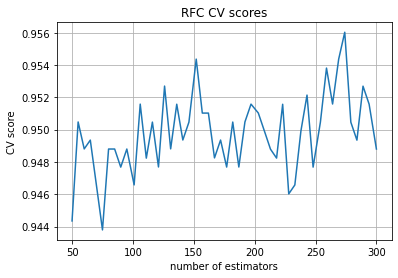

In [12]:
pyplot.grid(True)
pyplot.plot(n_estimators_sample, scores,)
pyplot.xlabel('number of estimators')
pyplot.ylabel('CV score')
pyplot.title('RFC CV scores')

На основе наблюдений выпишите через пробел номера правильных утверждений из приведенных ниже в порядке возрастания номера (это будет ответ в п.5)

1) Случайный лес сильно переобучается с ростом количества деревьев

2) При очень маленьком числе деревьев (5, 10, 15), случайный лес работает хуже, чем при большем числе деревьев

3) С ростом количества деревьев в случайном лесе, в какой-то момент деревьев становится достаточно для высокого качества классификации, а затем качество существенно не меняется.

4) При большом количестве признаков (для данного датасета - 40, 50) качество классификации становится хуже, чем при малом количестве признаков (5, 10). Это связано с тем, что чем меньше признаков выбирается в каждом узле, тем более различными получаются деревья (ведь деревья сильно неустойчивы к изменениям в обучающей выборке), и тем лучше работает их композиция.

5) При большом количестве признаков (40, 50, 60) качество классификации лучше, чем при малом количестве признаков (5, 10). Это связано с тем, что чем больше признаков - тем больше информации об объектах, а значит алгоритм может делать прогнозы более точно.

6) При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса намного лучше, чем без ограничения глубины, т.к. деревья получаются не переобученными. С ростом глубины деревьев качество ухудшается.

7) При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса заметно хуже, чем без ограничений, т.к. деревья получаются недообученными. С ростом глубины качество сначала улучшается, а затем не меняется существенно, т.к. из-за усреднения прогнозов и различий деревьев их переобученность в бэггинге не сказывается на итоговом качестве (все деревья преобучены по-разному, и при усреднении они компенсируют переобученность друг-друга).
